In [1]:
import json
import os
import sys
import timeit

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import mean_squared_error

sys.path.append(r"../")
from AssistanceTransform import transform, estimator

# Testing for optimal iterations vs. execution time

In [2]:
results = []
results_time = []
begin = 2
end = 5
time_settings = np.logspace(begin,end,num=end-begin+1,base=10,dtype='int')

In [3]:
time_settings

array([   100,   1000,  10000, 100000])

In [4]:
image_coord_dict = dict()
image_coord_dict["00.jpg"] = np.array([[1470, 1430], [2333, 1355], [3247, 1781], [1935, 1952]])
image_coord_dict["01.jpg"] = np.array([[1495, 1552], [2219, 1589], [1843, 1969], [805, 1875]])
image_coord_dict["03.jpg"] = np.array([[1216, 1398], [2215, 1754], [3268, 1530], [2067, 1282]])   

def setup_vars():
    """Loads data for test_transform_image"""
    data_dir = r"./data/table"
    json_fp = os.path.join(data_dir, "anno.json")
    arr_fp = os.path.join(data_dir, "anno.npz")
    with open(json_fp, "r") as fp:
        mappings = json.load(fp)

    with np.load(arr_fp) as arrs:
        anno_dict = {img: {"heads": arrs[f"{prefix}heads"],
                           "feet": arrs[f"{prefix}feet"]}
                     for img, prefix in mappings.items()}
    
    for key, items in anno_dict.items():
        if key.endswith("02.jpg"):
            continue
        else:
            image_coords = image_coord_dict[key[-6:]]
        # feet and heads have been swapped in annotations
        reference = np.array([items["feet"], items["heads"]])
        height = 0.095  # m
        STD = 0.01  # m
        img = Image.open(key)
        yield (img, reference, height, STD, image_coords)
        
params = next(setup_vars())

Approximately linear increase 

In [5]:
number = 10

for setting in time_settings:
    func = lambda: results.append(estimator.area(transform.transform_image(*params, iters=setting)[:,:2]))
    results_time.append(timeit.timeit(func, number=int(number)))
    print(f"{setting} iterations takes approx {results_time[-1] / number} seconds")

100 iterations takes approx 0.05472464000000001 seconds
1000 iterations takes approx 0.5274587100000001 seconds
10000 iterations takes approx 5.8066341800000005 seconds
100000 iterations takes approx 48.103476650000005 seconds


In [6]:
# convert to np.array
results_time = np.array(results_time)
results = np.array(results)

In [7]:
results_time / number

array([ 0.05472464,  0.52745871,  5.80663418, 48.10347665])

In [8]:
results

array([1.59395163, 2.0706934 , 1.6282009 , 1.20465669, 2.21069967,
       2.22648953, 1.38864159, 3.81025158, 1.49234109, 2.81503255,
       1.72182072, 1.56169143, 1.47773459, 1.31097936, 2.48980358,
       1.01908905, 1.06619647, 1.88533724, 1.08028603, 1.59763924,
       1.36441777, 1.50268121, 1.12153794, 1.48105989, 1.46563583,
       1.37363178, 1.67119527, 1.38805866, 1.4068433 , 1.50239314,
       1.43513308, 1.5292946 , 1.39972717, 1.5724085 , 0.87894861,
       1.47065521, 1.36639089, 1.29289772, 1.48820673, 1.50753946])

In [9]:
y_true = np.repeat(1.33455, results.size)

In [10]:
RMSE = []
for i in range(0, number * time_settings.size, number):
    RMSE.append(mean_squared_error(y_true[:number], results[i:i+number], squared=False))
    print(RMSE[-1])
    
    
# mean_squared_error(y_true, results, squared=False)

1.0307397638995301
0.465403265626847
0.16257343176367495
0.197800125391702


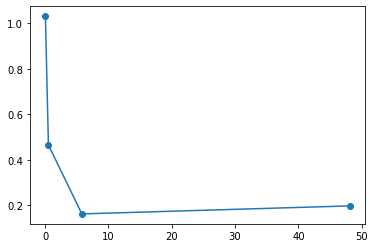

In [12]:
plt.scatter(results_time / number, RMSE)
plt.plot(results_time / number, RMSE)
plt.show()

For small scale experiments, 1e4 seems to be the optimal time-performance option. 